In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

In [2]:
import bbknn

In [3]:
#human data cross test
test = sc.read_h5ad('../data/as2_3803_HS.h5ad')
test2 = sc.read_h5ad('../data/as1_3803_HS.h5ad')

In [4]:
positive = sc.read_h5ad('../data/AS2_3803_adata_filtered_log1p_norm_scaled_FS.h5ad')
positive2 = sc.read_h5ad('../data/AS1_3803_adata_filtered_log1p_norm_scaled_FS.h5ad')

In [5]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(test)
reorder_adata(test2)
# create new "observations" as percent and mean mito genes
test2.var['mito'] = test2.var_names.str.contains('MT-') # identify mitochondrial genes
test2.obs['mean_mito'] = np.mean(test2[:,test2.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test2, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# create new "observations" as percent and mean mito genes
test.var['mito'] = test.var_names.str.contains('MT-') # identify mitochondrial genes
test.obs['mean_mito'] = np.mean(test[:,test.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# rank cells by total counts and save as .obs
test2.obs['ranked_total_counts'] = np.argsort(test2.obs['total_counts'])
test.obs['ranked_total_counts'] = np.argsort(test.obs['total_counts'])

Wall time: 4.91 s


In [6]:
#For Bob's Filter
f1 = np.isin(test.obs.index, positive.obs.index)
test.obs['bob_filter']=0
test.obs.loc[f1, 'bob_filter'] = 1
        
f2 = np.isin(test2.obs.index, positive2.obs.index)
test2.obs['bob_filter']=0
test2.obs.loc[f2, 'bob_filter'] = 1

In [7]:
#Common gene index search
common = np.isin(test.var.index, test2.var.index)
#Common gene list + new anndata
common_gene= []
for i in range(0,len(common)):
    if common[i]:
        common_gene.append(test.var.index[i])

In [8]:
#new anndata
test_common_genes = test[:, common_gene]
test2_common_genes = test2[:, common_gene]

In [9]:
test_common_genes.obs['set'] = 'train'
test2_common_genes.obs['set'] = 'test'

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [10]:
merge_data = test_common_genes.concatenate(test2_common_genes)

In [11]:
%%time
sc.pp.normalize_total(merge_data, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(merge_data) # log1p transformation
sc.pp.scale(merge_data, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 8 s


In [12]:
%%time
sc.pp.normalize_total(test2_common_genes, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(test2_common_genes) # log1p transformation
sc.pp.scale(test2_common_genes, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 3.44 s


... storing 'set' as categorical


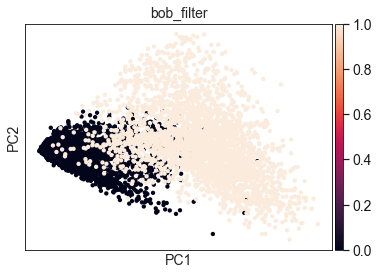

... storing 'set' as categorical


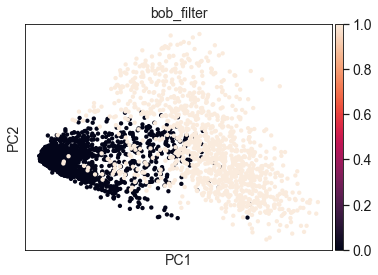

In [13]:
sc.tl.pca(merge_data, n_comps=100) # perform PCA and plot results
sc.pl.pca(merge_data, color=['bob_filter'], ncols=4, size=75)
sc.tl.pca(test2_common_genes, n_comps=10) # perform PCA and plot results
sc.pl.pca(test2_common_genes, color=['bob_filter'], ncols=4, size=75)

In [14]:
merge_data.obsm['X_pca']

array([[ 6.1217064e+01, -1.6063362e+00, -1.8774717e+01, ...,
        -1.3251014e+00,  3.2806572e-01,  2.2120911e-01],
       [ 5.7767918e+01, -2.2563200e+01, -1.0170240e+01, ...,
         9.6694961e-02,  4.1118595e-01,  4.7519565e-01],
       [ 4.0606934e+01,  6.1656632e+00, -1.2488768e+01, ...,
         2.0186245e+00,  1.9463223e+00,  1.9906768e-01],
       ...,
       [-2.0032137e+01, -1.5601296e+00,  2.2170351e+00, ...,
        -3.0641076e-01, -8.6499083e-01, -4.5376584e-01],
       [-2.0178932e+01, -3.0006962e+00,  6.1499648e+00, ...,
        -2.0173901e-01,  4.7656760e-01,  5.7472140e-02],
       [-1.8834385e+01,  4.2362275e+00,  1.4965963e+00, ...,
         7.1911019e-01,  6.7132056e-01,  4.3597877e-01]], dtype=float32)

In [15]:
array1 = np.where(merge_data.obs['set']== 'train')
array2 = np.where(merge_data.obs['set']== 'test')
X=merge_data.obsm['X_pca'] 
y=merge_data.obs['bob_filter']

rf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=2)
lr = LogisticRegressionCV(cv=5, random_state=2, multi_class='multinomial', max_iter=1000)

lr.fit(X[array1[0]], y[array1[0]])
prediction = lr.predict(X[array2[0]])
test2_common_genes.obs['binary']=prediction


In [16]:
f_positive = 0
f_negative = 0
for i in range(0,len(test2)):
    if test2_common_genes.obs['binary'][i]-test2_common_genes.obs['bob_filter'][i]>0:
        f_positive +=1
    if test2_common_genes.obs['binary'][i]-test2_common_genes.obs['bob_filter'][i]<0:
        f_negative +=1
total_acc = 1-((f_negative)/sum(test2.obs['bob_filter']))
print('miss-labeled as cell:',f_positive,'; mislabeled as empty:',f_negative,'; correct N-label percent is %0.2f)' % total_acc)

miss-labeled as cell: 205 ; mislabeled as empty: 38 ; correct N-label percent is 0.97)


In [ ]:
sc.tl.tsne(test2_common_genes, n_pcs=2,n_jobs=-1) # perform tsne and plot results
sc.pl.tsne(test2_common_genes, color=['log1p_total_counts','pct_counts_mito','binary','bob_filter'], ncols=4, size=75)